In [12]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import mnist
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [56]:
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])
  
  hid = Dense(128 * 7 * 7, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((7, 7, 128))(hid)

  hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(1, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  
  return model, out

In [57]:
def get_discriminator(input_layer, condition_layer):
  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  
  merged_layer = Concatenate()([hid, condition_layer])
  hid = Dense(512, activation='relu')(merged_layer)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)

  model.summary()

  return model, out

In [58]:
from keras.preprocessing import image

def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y

tags = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  
def show_samples(batchidx):
  fig, axs = plt.subplots(5, 6, figsize=(10,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
  #fig, axs = plt.subplots(5, 6)
  #fig.tight_layout()
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * 3)
    noise = generate_noise(3, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
          axs[row,i+coloffset].set_title(tags[classlabel])
  plt.show()
  plt.close()

In [59]:
# GAN creation
img_input = Input(shape=(28,28,1))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan_input = Input(shape=(100,))
x = generator([gan_input, gen_condition_input])
gan_out = discriminator([x, disc_condition_input])
gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 128)  1280        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 28, 28, 128)  512         conv2d_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 28, 28, 128)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_11 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 28, 28, 1)    2743553     input_15[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10)           0                                            
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


In [60]:

BATCH_SIZE = 100

# # Get training images
(X_train, y_train), (X_test, _) = mnist.load_data()

# Normalize data
X_train = (X_train - 127.5) / 127.5

# 1hot encode labels
y_train = one_hot_encode(y_train[:])

print ("Training shape: {}".format(X_train.shape))
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Training shape: (60000, 28, 28)


In [61]:
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [62]:
y_train.shape

(60000, 10)

In [63]:
x=X_train
x = x.reshape((60000, 28, 28, 1))


In [64]:
x.shape

(60000, 28, 28, 1)

In [65]:
X_train=x

In [66]:
# Array to store samples for experience replay
exp_replay = []

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


	Epoch: 1, Generator Loss: 0.3434099139273167, Discriminator Loss: [0.07496192 0.        ]


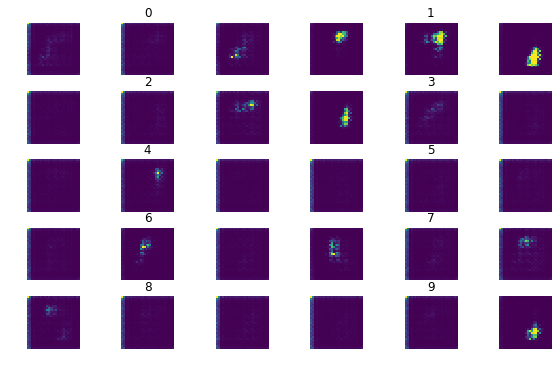

	Epoch: 2, Generator Loss: 0.25745565004646775, Discriminator Loss: [0.073961 0.      ]


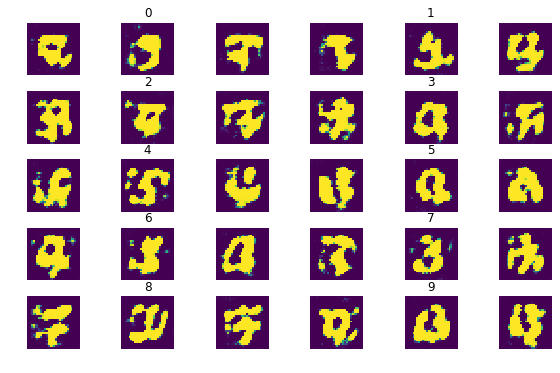

	Epoch: 3, Generator Loss: 0.24724378218253454, Discriminator Loss: [0.08284142 0.        ]


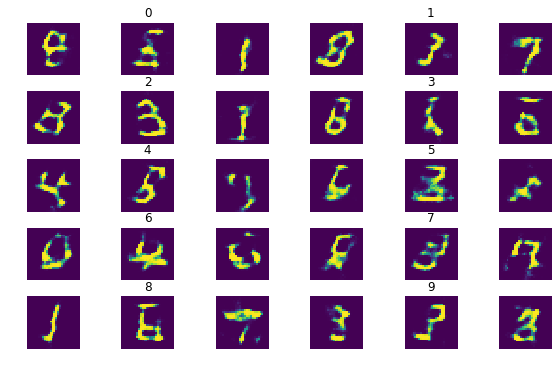

	Epoch: 4, Generator Loss: 0.26007155150175093, Discriminator Loss: [0.0915077 0.       ]


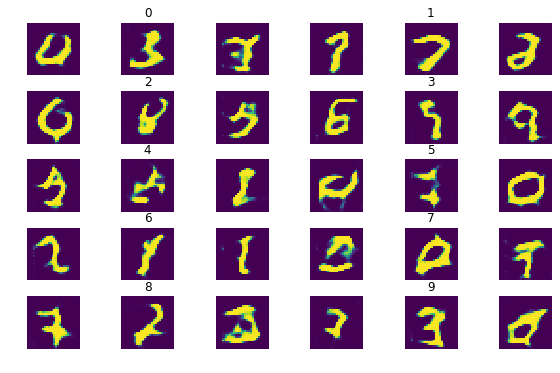

	Epoch: 5, Generator Loss: 0.29500795821348824, Discriminator Loss: [0.08291424 0.        ]


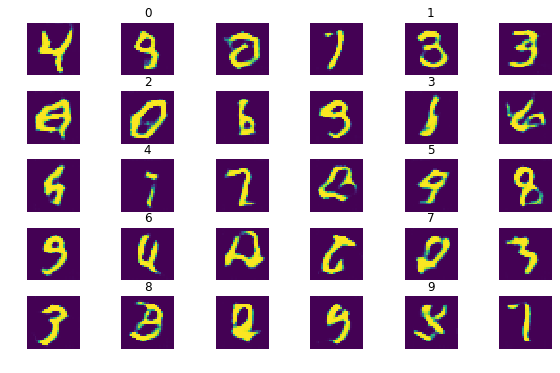

	Epoch: 6, Generator Loss: 0.2451233704884847, Discriminator Loss: [0.09252332 0.        ]


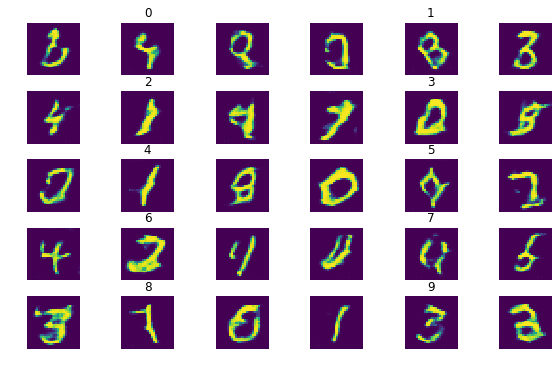

	Epoch: 7, Generator Loss: 0.2656157211462657, Discriminator Loss: [0.08762351 0.        ]


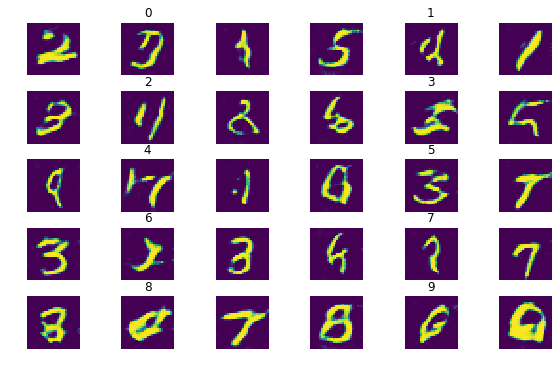

	Epoch: 8, Generator Loss: 0.2704403056701024, Discriminator Loss: [0.08672535 0.        ]


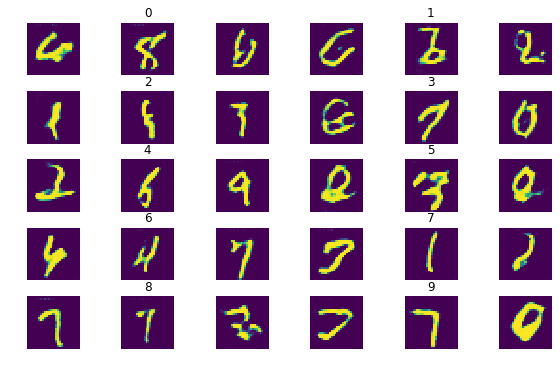

	Epoch: 9, Generator Loss: 0.28288829227288564, Discriminator Loss: [0.08444833 0.        ]


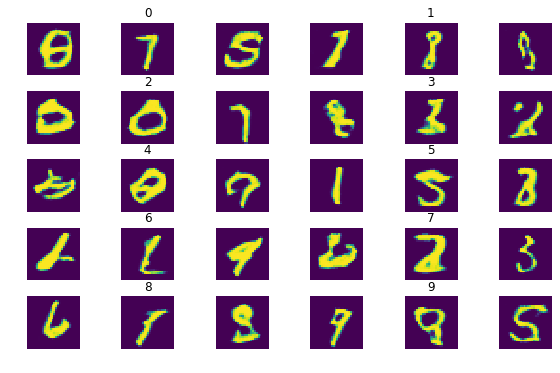

	Epoch: 10, Generator Loss: 0.27244146684805554, Discriminator Loss: [0.0846053 0.       ]


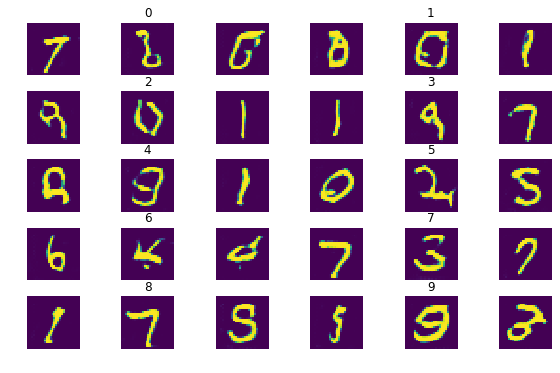

	Epoch: 11, Generator Loss: 0.2837431138753891, Discriminator Loss: [0.08264051 0.        ]


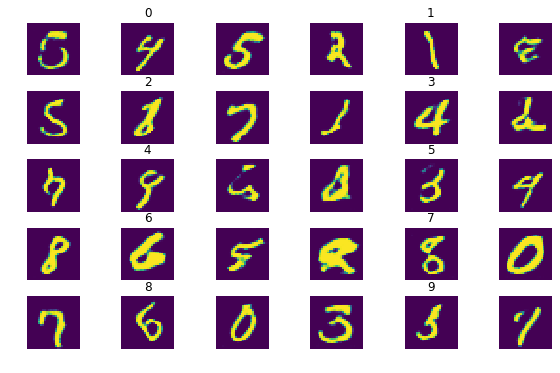

	Epoch: 12, Generator Loss: 0.2636981858809789, Discriminator Loss: [0.08637054 0.        ]


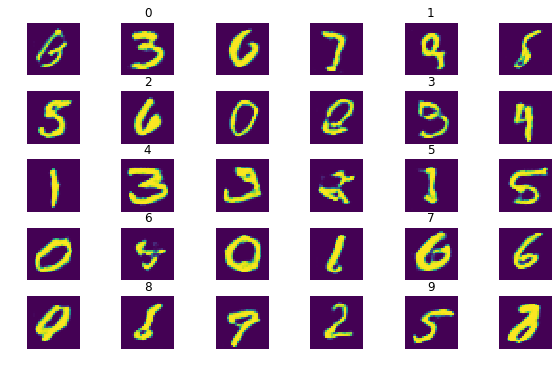

	Epoch: 13, Generator Loss: 0.2703926455974579, Discriminator Loss: [0.08569052 0.        ]


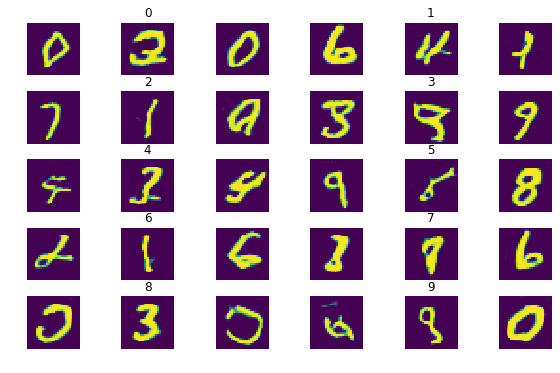

	Epoch: 14, Generator Loss: 0.27699370980262755, Discriminator Loss: [0.08321857 0.        ]


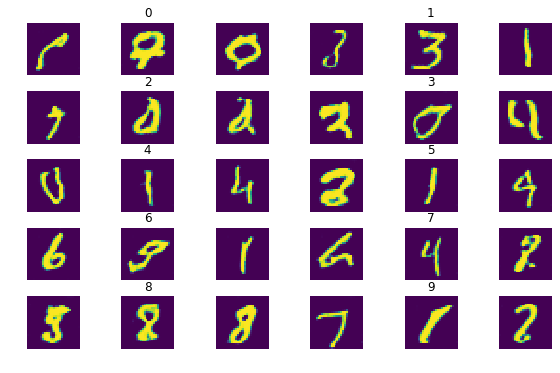

	Epoch: 15, Generator Loss: 0.28330098470052084, Discriminator Loss: [0.08209378 0.        ]


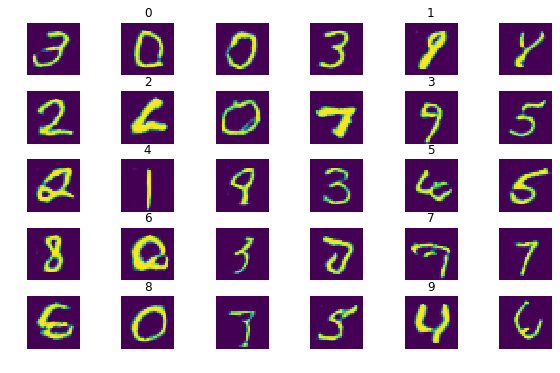

	Epoch: 16, Generator Loss: 0.29178414384524026, Discriminator Loss: [0.080736 0.      ]


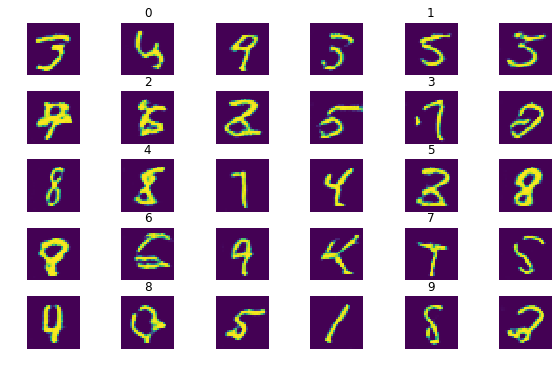

	Epoch: 17, Generator Loss: 0.27278651694456735, Discriminator Loss: [0.0839181 0.       ]


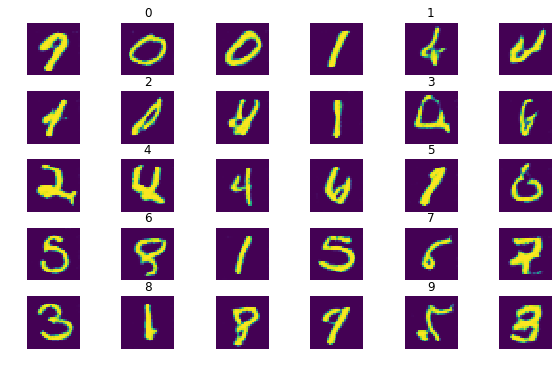

	Epoch: 18, Generator Loss: 0.28478678266207375, Discriminator Loss: [0.08137615 0.        ]


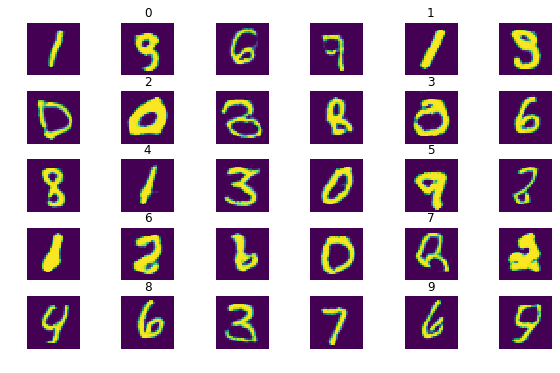

	Epoch: 19, Generator Loss: 0.2824481254816055, Discriminator Loss: [0.082117 0.      ]


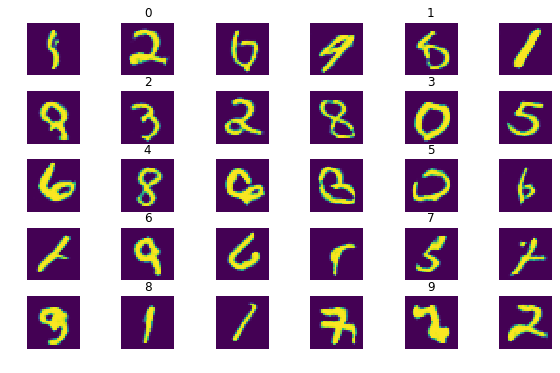

	Epoch: 20, Generator Loss: 0.296753743092219, Discriminator Loss: [0.07969143 0.        ]


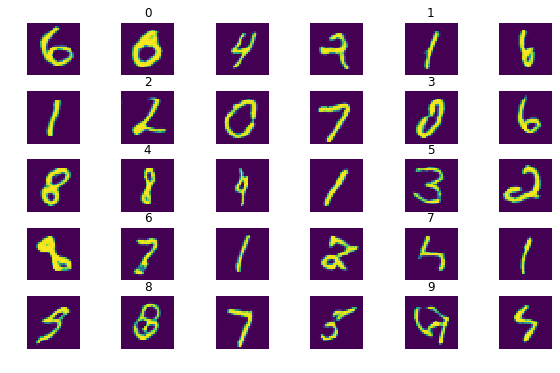

	Epoch: 21, Generator Loss: 0.2967025639613469, Discriminator Loss: [0.07975867 0.        ]


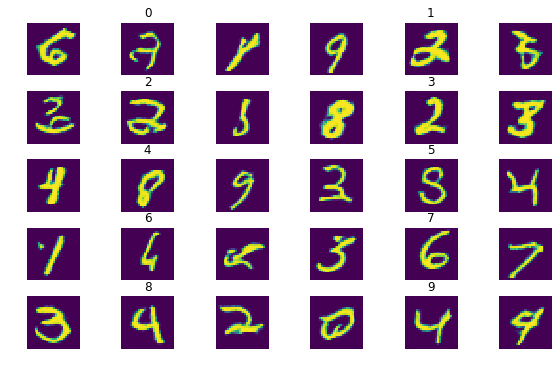

	Epoch: 22, Generator Loss: 0.29175596634546913, Discriminator Loss: [0.07979365 0.        ]


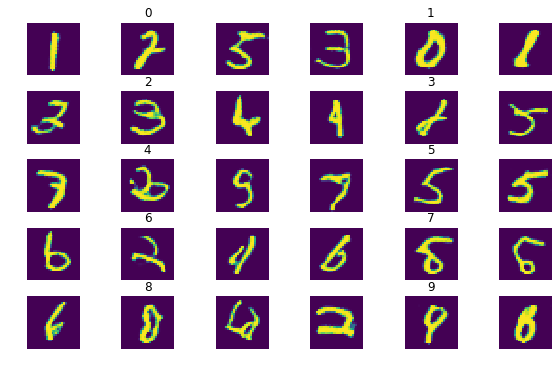

	Epoch: 23, Generator Loss: 0.29811917861302695, Discriminator Loss: [0.07986236 0.        ]


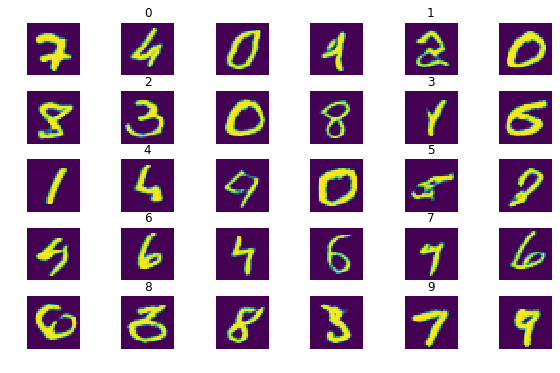

	Epoch: 24, Generator Loss: 0.3063542890548706, Discriminator Loss: [0.07901455 0.        ]


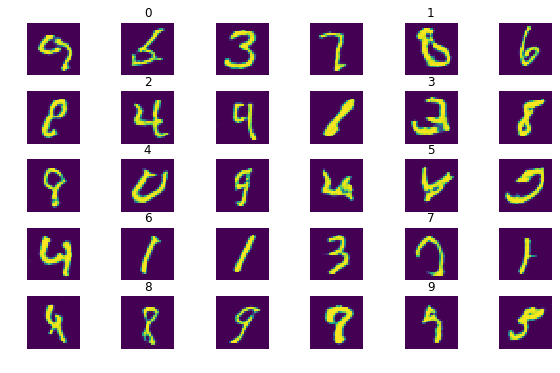

	Epoch: 25, Generator Loss: 0.3020699987808863, Discriminator Loss: [0.08033144 0.        ]


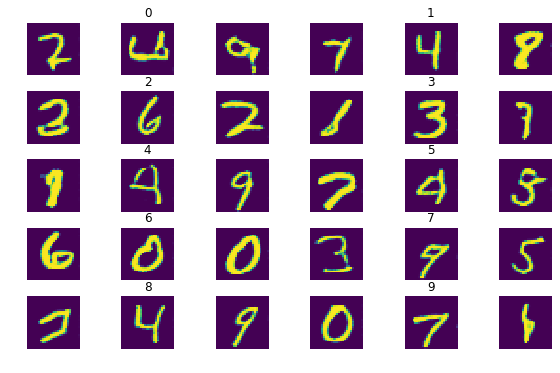

	Epoch: 26, Generator Loss: 0.3122998332977295, Discriminator Loss: [0.0779746 0.       ]


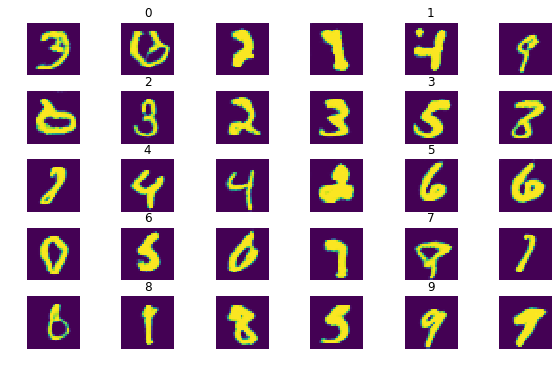

	Epoch: 27, Generator Loss: 0.30739907224973045, Discriminator Loss: [0.07856618 0.        ]


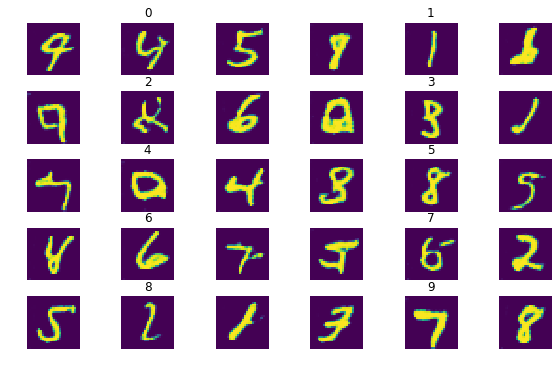

	Epoch: 28, Generator Loss: 0.30609232167402906, Discriminator Loss: [0.08090299 0.        ]


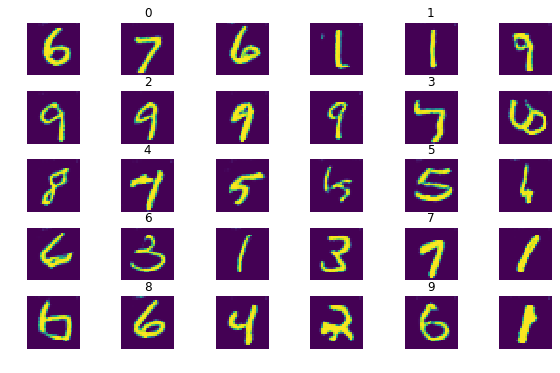

	Epoch: 29, Generator Loss: 0.29686862031618755, Discriminator Loss: [0.07970258 0.        ]


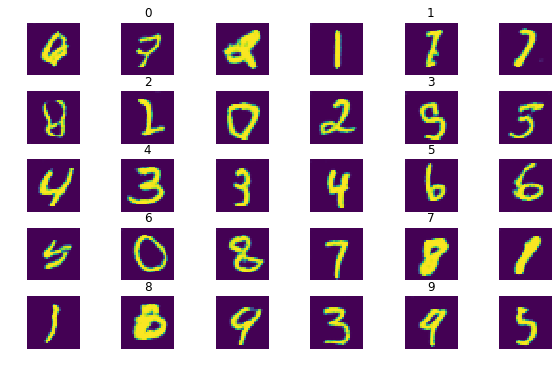

	Epoch: 30, Generator Loss: 0.30417077561219535, Discriminator Loss: [0.08007783 0.        ]


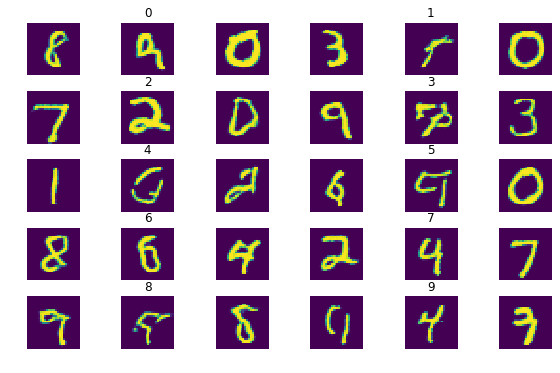

	Epoch: 31, Generator Loss: 0.3053171177705129, Discriminator Loss: [0.07914341 0.        ]


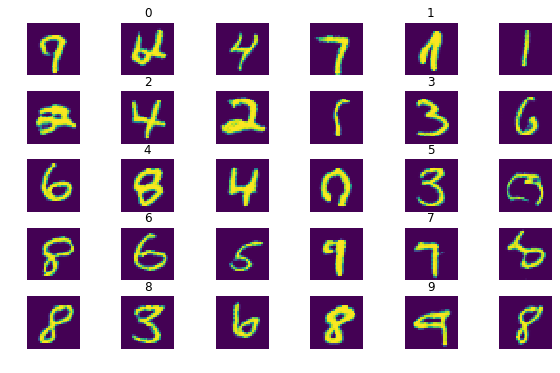

	Epoch: 32, Generator Loss: 0.31076239347457885, Discriminator Loss: [0.0784663 0.       ]


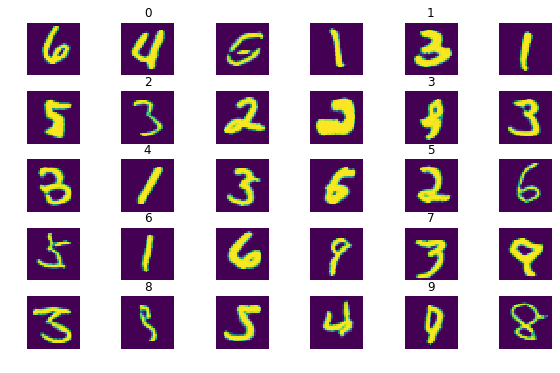

	Epoch: 33, Generator Loss: 0.30718069553375243, Discriminator Loss: [0.0800641 0.       ]


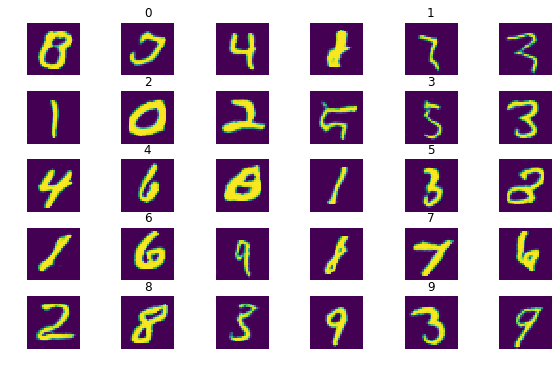

	Epoch: 34, Generator Loss: 0.314464870095253, Discriminator Loss: [0.07893009 0.        ]


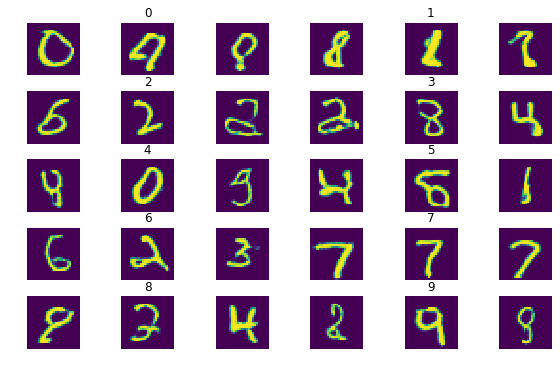

	Epoch: 35, Generator Loss: 0.306404061516126, Discriminator Loss: [0.08036596 0.        ]


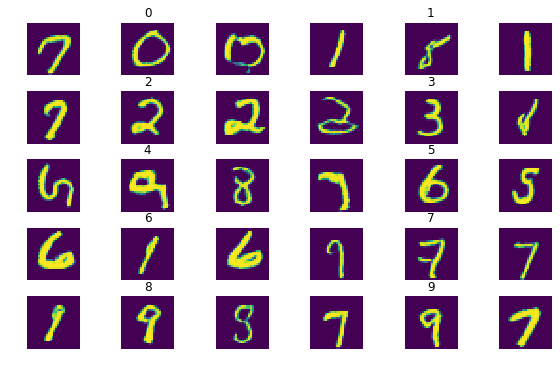

	Epoch: 36, Generator Loss: 0.3021134525537491, Discriminator Loss: [0.08239241 0.        ]


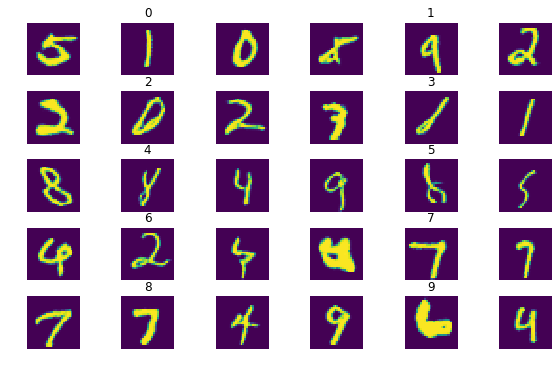

	Epoch: 37, Generator Loss: 0.2960006296634674, Discriminator Loss: [0.08340144 0.        ]


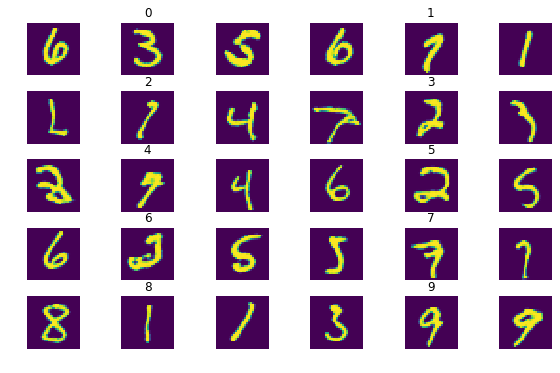

	Epoch: 38, Generator Loss: 0.2957372575998306, Discriminator Loss: [0.08176453 0.        ]


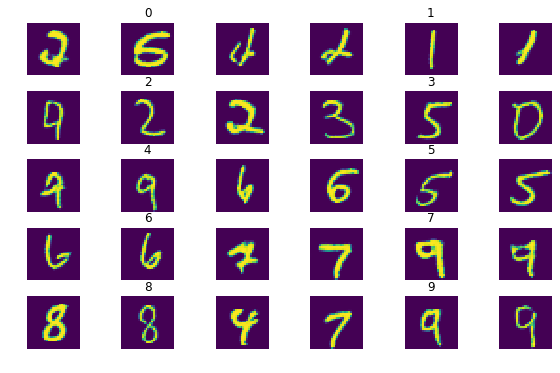

	Epoch: 39, Generator Loss: 0.30174008786678314, Discriminator Loss: [0.081989 0.      ]


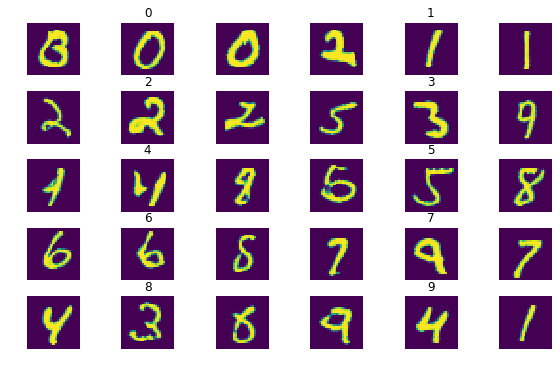

	Epoch: 40, Generator Loss: 0.28691116253534954, Discriminator Loss: [0.08479156 0.        ]


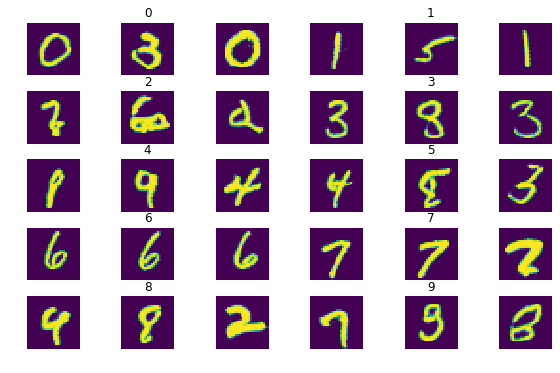

	Epoch: 41, Generator Loss: 0.28961430668830873, Discriminator Loss: [0.08466615 0.        ]


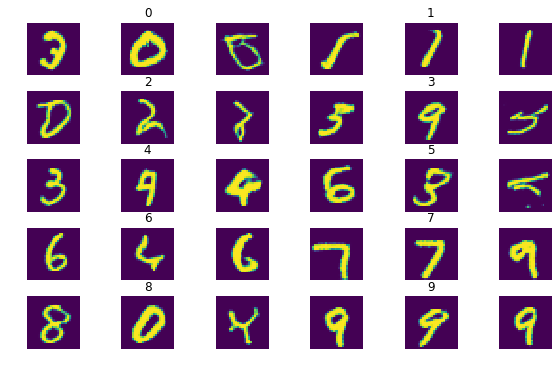

	Epoch: 42, Generator Loss: 0.2885478812456131, Discriminator Loss: [0.08474157 0.        ]


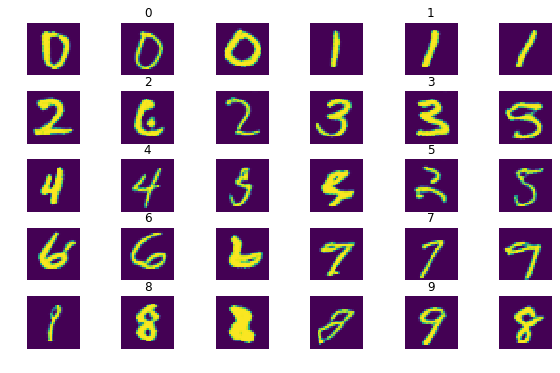

	Epoch: 43, Generator Loss: 0.2752834091583888, Discriminator Loss: [0.08817243 0.        ]


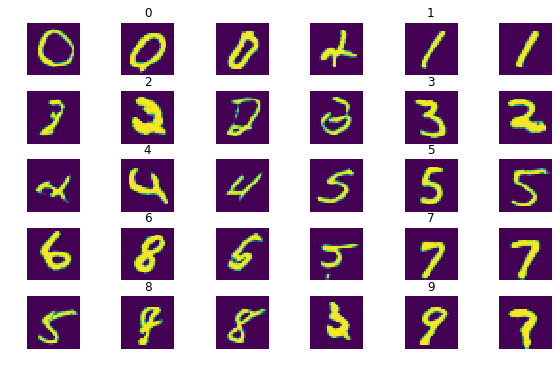

	Epoch: 44, Generator Loss: 0.26382599035898846, Discriminator Loss: [0.08876264 0.        ]


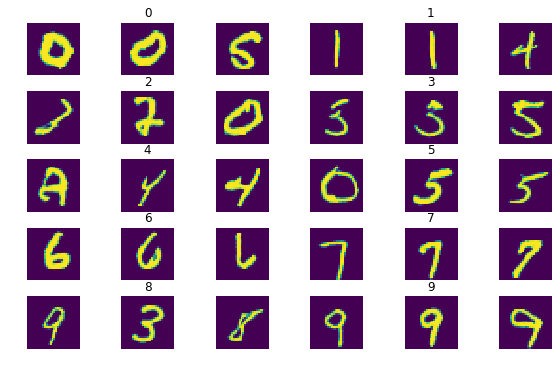

	Epoch: 45, Generator Loss: 0.2621245718002319, Discriminator Loss: [0.08888822 0.        ]


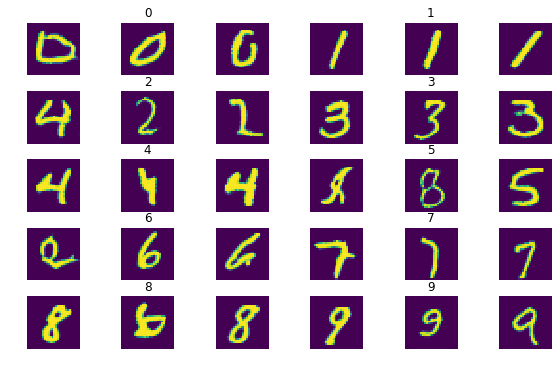

	Epoch: 46, Generator Loss: 0.2604693512121836, Discriminator Loss: [0.08977421 0.        ]


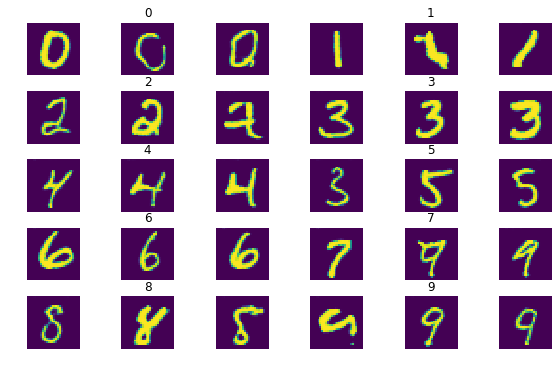

	Epoch: 47, Generator Loss: 0.2634405545393626, Discriminator Loss: [0.08950701 0.        ]


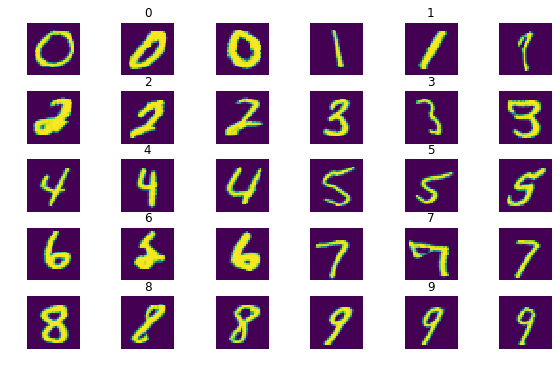

	Epoch: 48, Generator Loss: 0.26346639533837635, Discriminator Loss: [0.08883145 0.        ]


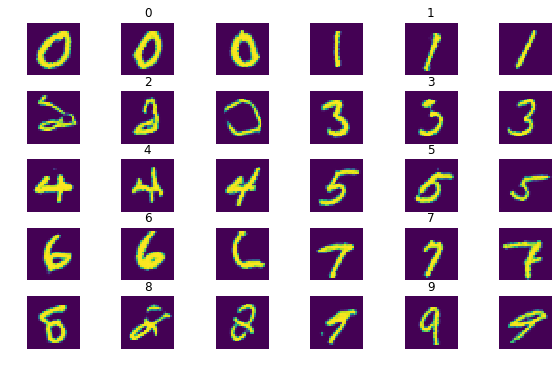

	Epoch: 49, Generator Loss: 0.26889649788538617, Discriminator Loss: [0.08907621 0.        ]


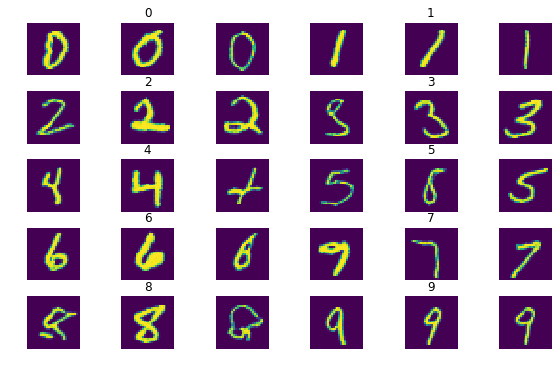

	Epoch: 50, Generator Loss: 0.262035270134608, Discriminator Loss: [0.08907387 0.        ]


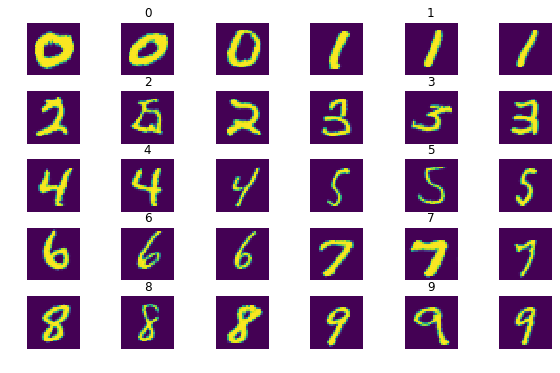

	Epoch: 51, Generator Loss: 0.2742012757062912, Discriminator Loss: [0.08719735 0.        ]


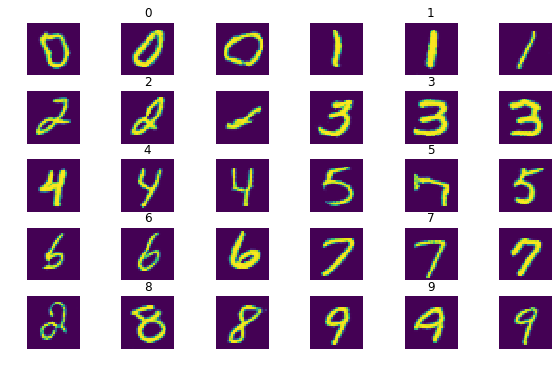

	Epoch: 52, Generator Loss: 0.2678712137540181, Discriminator Loss: [0.08761413 0.        ]


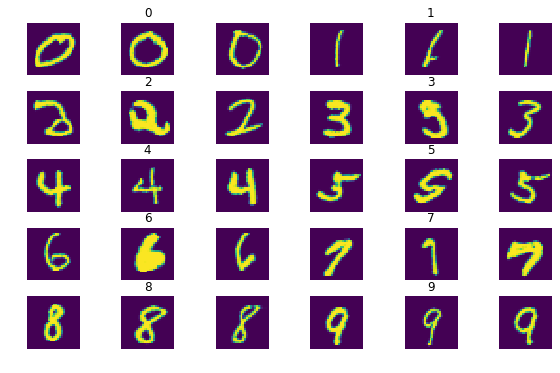

	Epoch: 53, Generator Loss: 0.27210234065850575, Discriminator Loss: [0.08699417 0.        ]


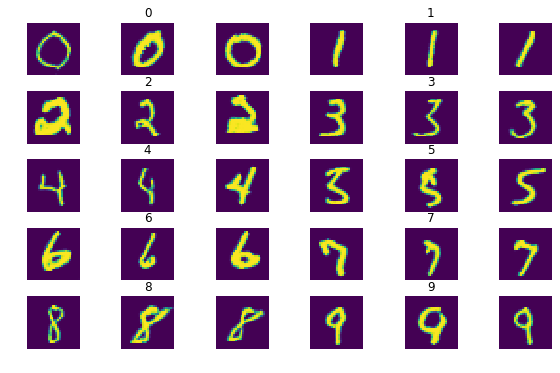

	Epoch: 54, Generator Loss: 0.2820823955535889, Discriminator Loss: [0.08731379 0.        ]


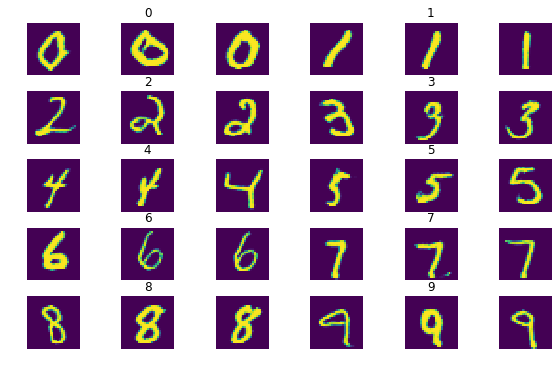

	Epoch: 55, Generator Loss: 0.27743788063526154, Discriminator Loss: [0.08602953 0.        ]


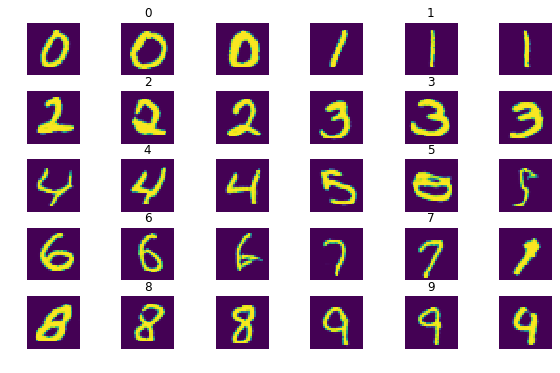

	Epoch: 56, Generator Loss: 0.2745492176214854, Discriminator Loss: [0.08575793 0.        ]


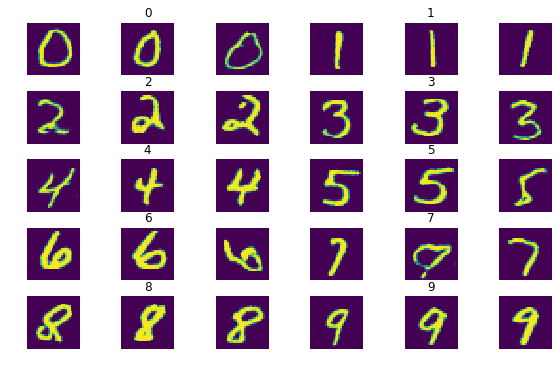

	Epoch: 57, Generator Loss: 0.2897626173496246, Discriminator Loss: [0.08493724 0.        ]


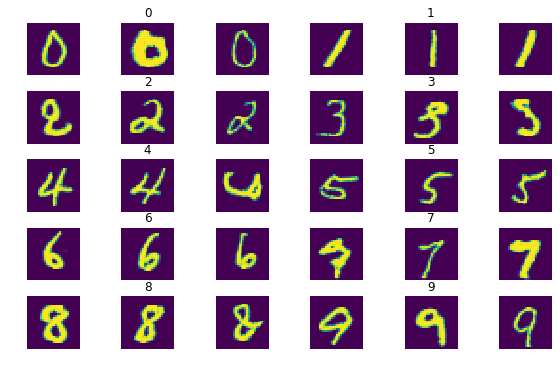

	Epoch: 58, Generator Loss: 0.28534898042678836, Discriminator Loss: [0.08494063 0.        ]


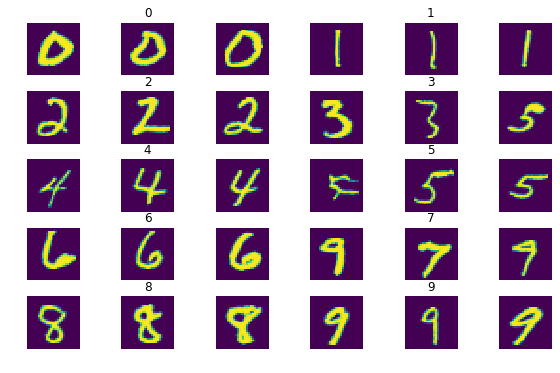

	Epoch: 59, Generator Loss: 0.28927477439244587, Discriminator Loss: [0.08344482 0.        ]


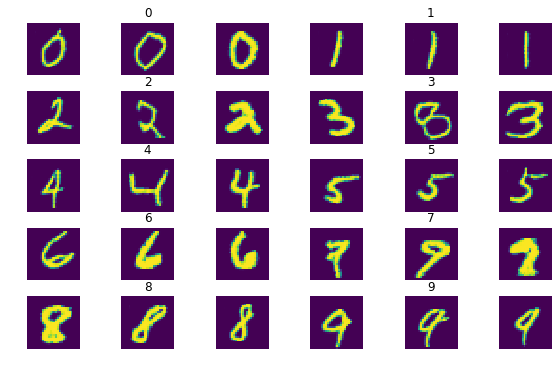

	Epoch: 60, Generator Loss: 0.2976030987501144, Discriminator Loss: [0.0826867 0.       ]


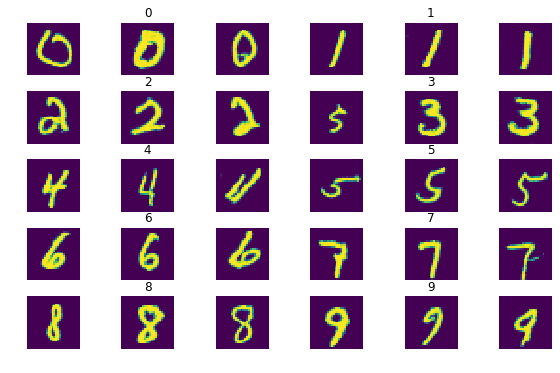

	Epoch: 61, Generator Loss: 0.2972181361913681, Discriminator Loss: [0.0836262 0.       ]


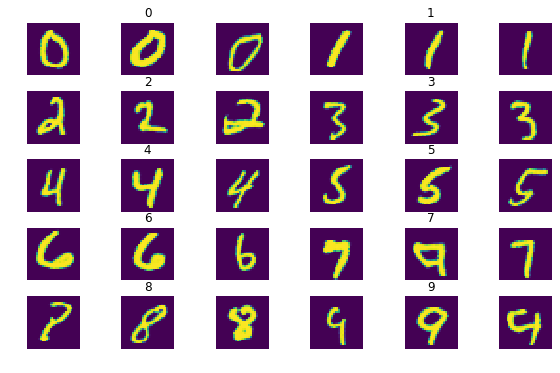

	Epoch: 62, Generator Loss: 0.29945420583089194, Discriminator Loss: [0.08230799 0.        ]


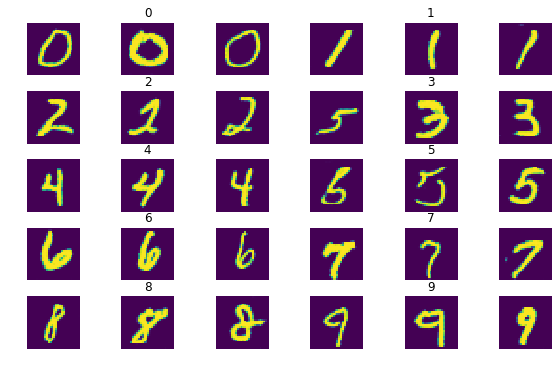

	Epoch: 63, Generator Loss: 0.304350222547849, Discriminator Loss: [0.08189902 0.        ]


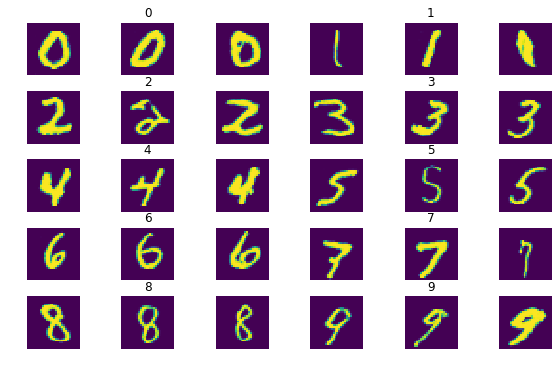

	Epoch: 64, Generator Loss: 0.30610334893067676, Discriminator Loss: [0.08157554 0.        ]


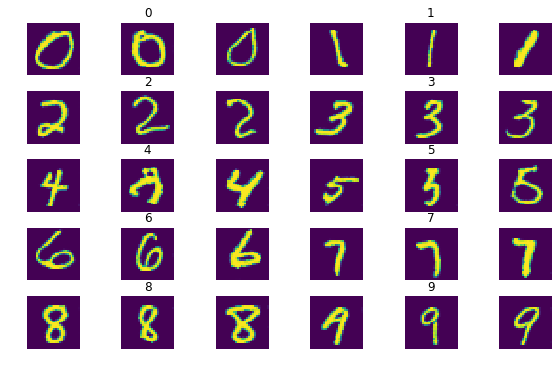

	Epoch: 65, Generator Loss: 0.3047437177101771, Discriminator Loss: [0.08155127 0.        ]


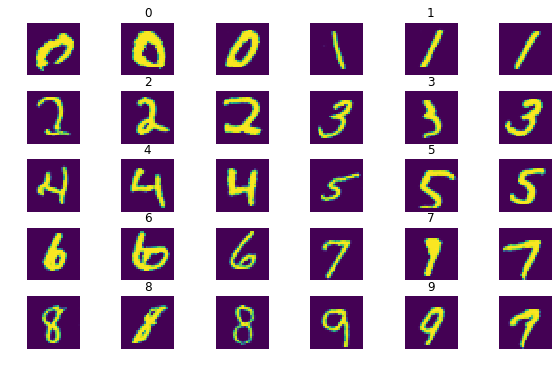

	Epoch: 66, Generator Loss: 0.31714625875155134, Discriminator Loss: [0.07918163 0.        ]


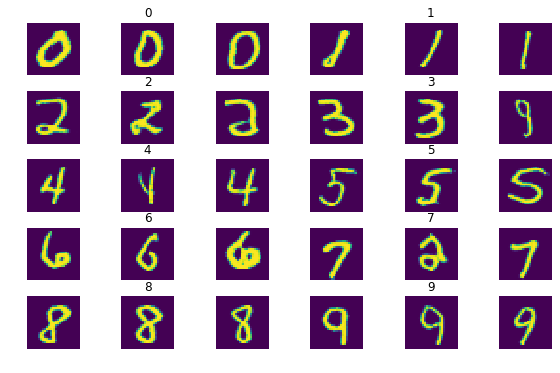

	Epoch: 67, Generator Loss: 0.3183421591917674, Discriminator Loss: [0.07895296 0.        ]


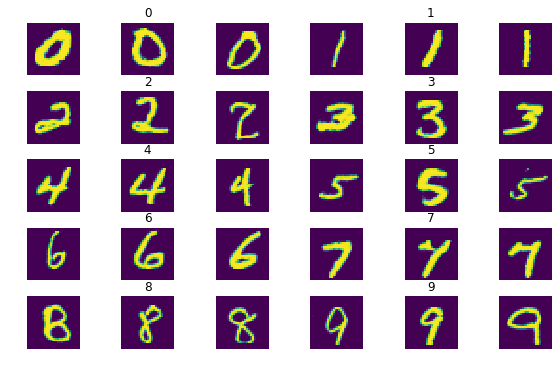

	Epoch: 68, Generator Loss: 0.31942800879478456, Discriminator Loss: [0.07892646 0.        ]


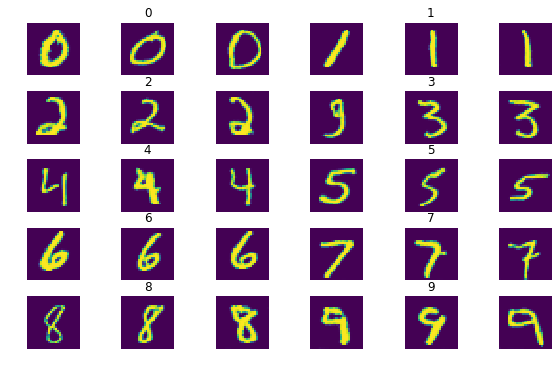

	Epoch: 69, Generator Loss: 0.3195314621925354, Discriminator Loss: [0.07822548 0.        ]


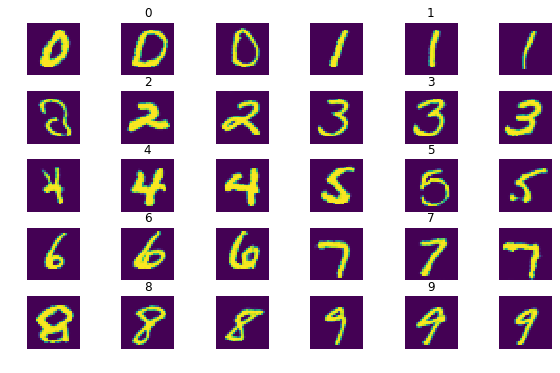

	Epoch: 70, Generator Loss: 0.3262341199318568, Discriminator Loss: [0.07727883 0.        ]


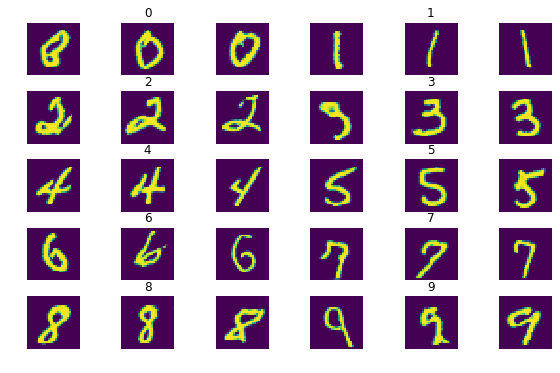

	Epoch: 71, Generator Loss: 0.3278521488110224, Discriminator Loss: [0.07779734 0.        ]


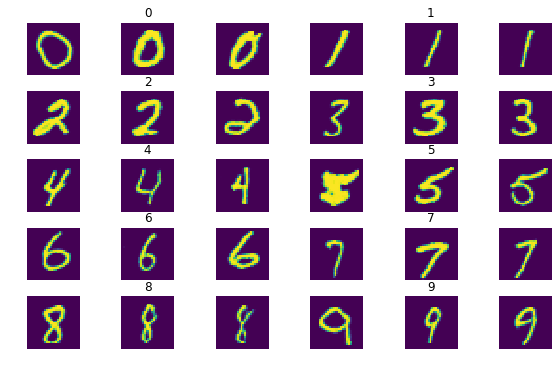

	Epoch: 72, Generator Loss: 0.3323928109804789, Discriminator Loss: [0.07696208 0.        ]


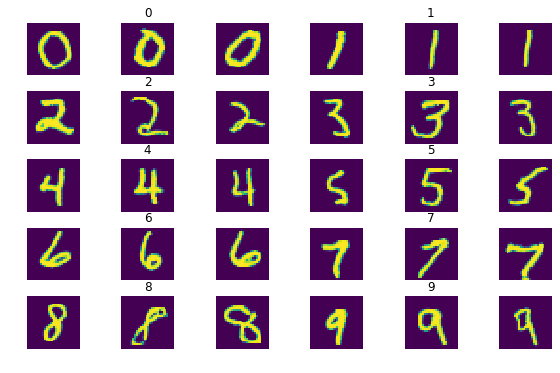

	Epoch: 73, Generator Loss: 0.33139439404010773, Discriminator Loss: [0.07674078 0.        ]


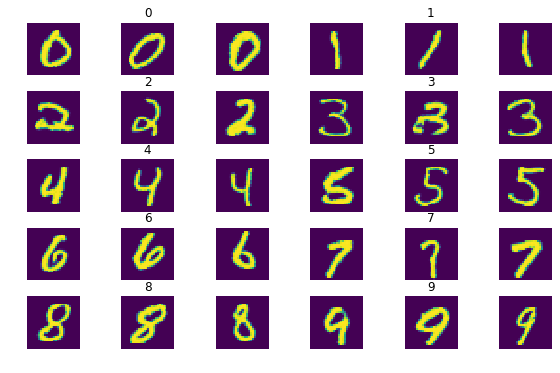

	Epoch: 74, Generator Loss: 0.33372368474801384, Discriminator Loss: [0.07658508 0.        ]


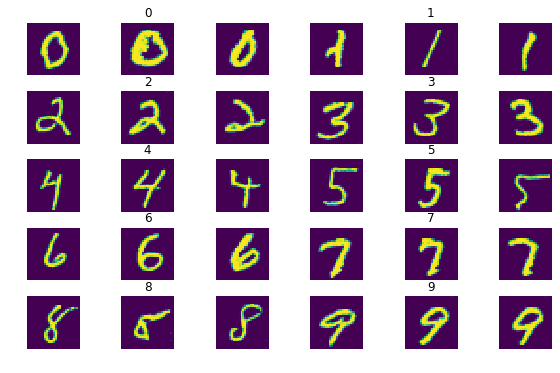

	Epoch: 75, Generator Loss: 0.3351620264848073, Discriminator Loss: [0.0765706 0.       ]


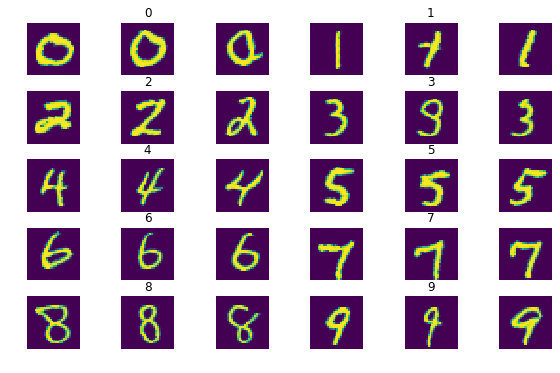

	Epoch: 76, Generator Loss: 0.3427453313271205, Discriminator Loss: [0.07510497 0.        ]


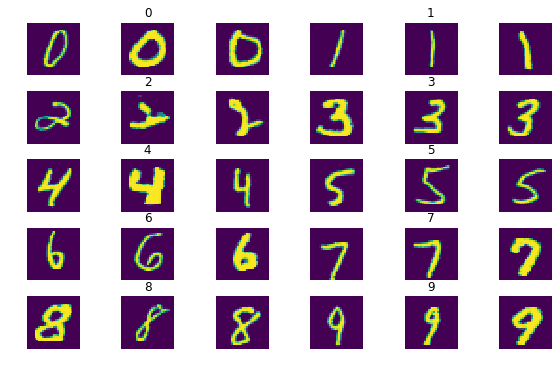

	Epoch: 77, Generator Loss: 0.3418556421995163, Discriminator Loss: [0.07527626 0.        ]


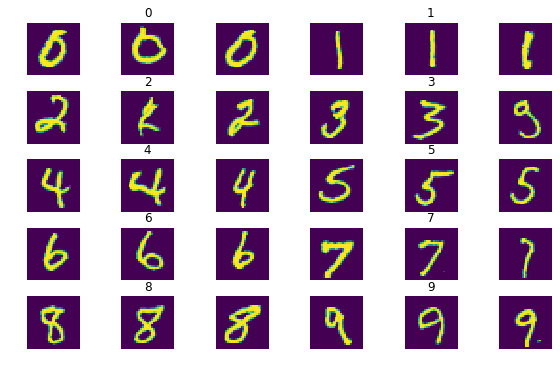

	Epoch: 78, Generator Loss: 0.33944721341133116, Discriminator Loss: [0.07634418 0.        ]


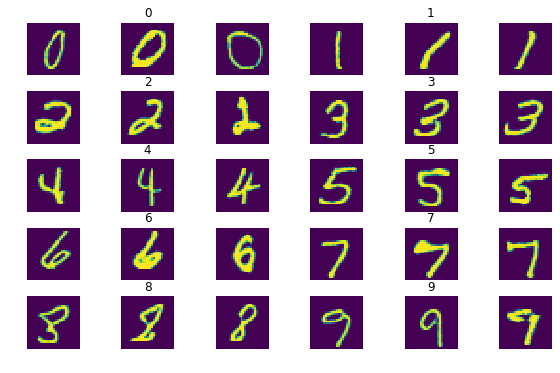

	Epoch: 79, Generator Loss: 0.3496411563952764, Discriminator Loss: [0.07440671 0.        ]


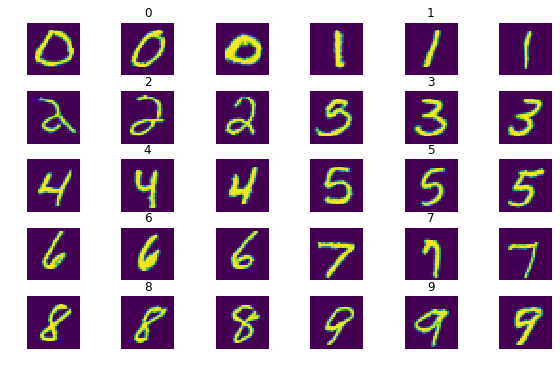

	Epoch: 80, Generator Loss: 0.3430003368854523, Discriminator Loss: [0.07477111 0.        ]


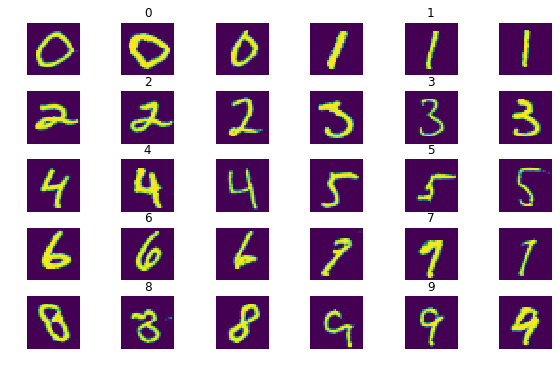

	Epoch: 81, Generator Loss: 0.3480146712064743, Discriminator Loss: [0.07362377 0.        ]


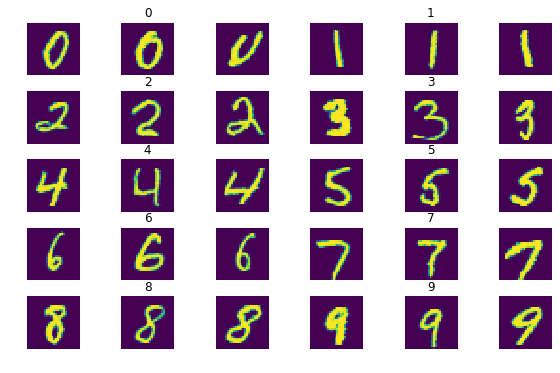

	Epoch: 82, Generator Loss: 0.3535212864478429, Discriminator Loss: [0.0733393 0.       ]


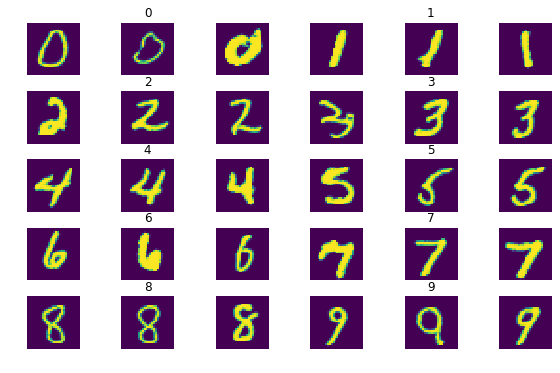

	Epoch: 83, Generator Loss: 0.3471319075425466, Discriminator Loss: [0.07408185 0.        ]


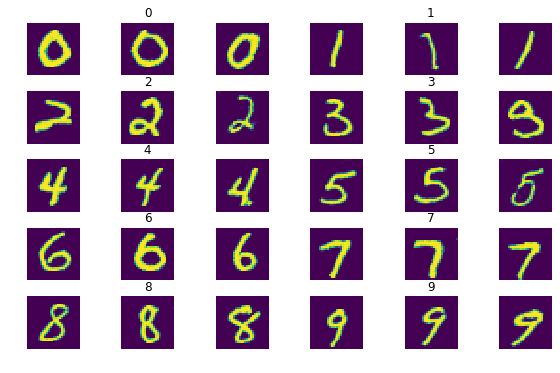

	Epoch: 84, Generator Loss: 0.3565513090292613, Discriminator Loss: [0.07272343 0.        ]


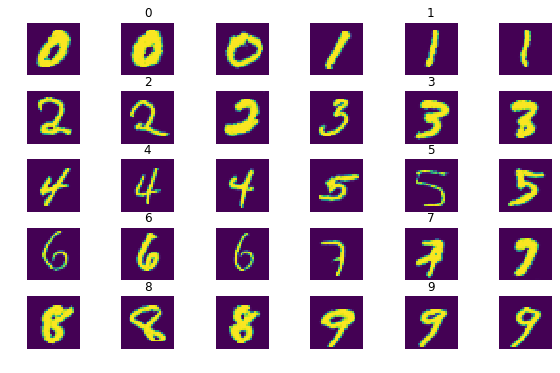

	Epoch: 85, Generator Loss: 0.35485915501912435, Discriminator Loss: [0.07290454 0.        ]


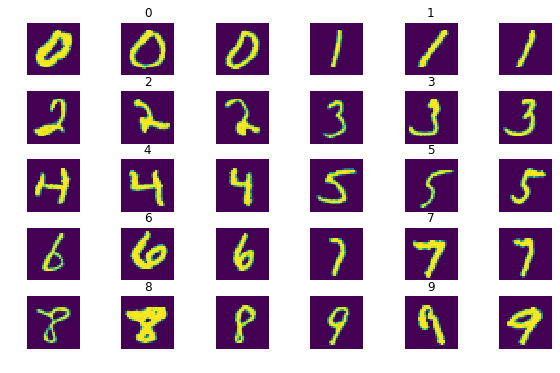

	Epoch: 86, Generator Loss: 0.3515459640820821, Discriminator Loss: [0.0728263 0.       ]


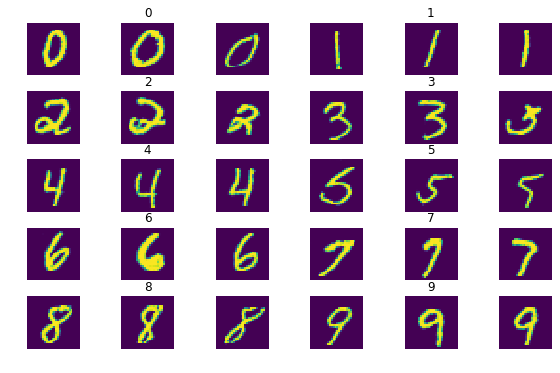

	Epoch: 87, Generator Loss: 0.35923282206058504, Discriminator Loss: [0.07241134 0.        ]


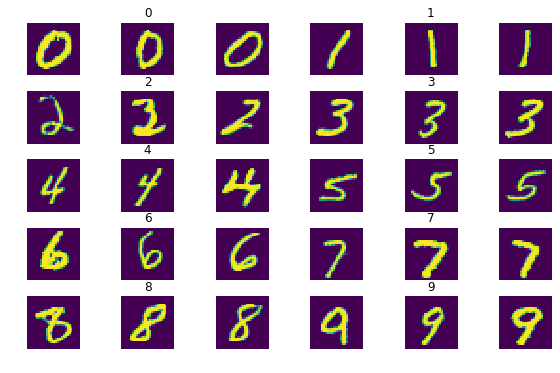

	Epoch: 88, Generator Loss: 0.36176527361075084, Discriminator Loss: [0.07252169 0.        ]


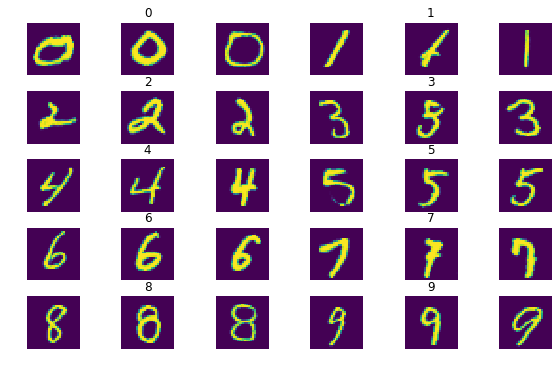

	Epoch: 89, Generator Loss: 0.35743545413017275, Discriminator Loss: [0.07178108 0.        ]


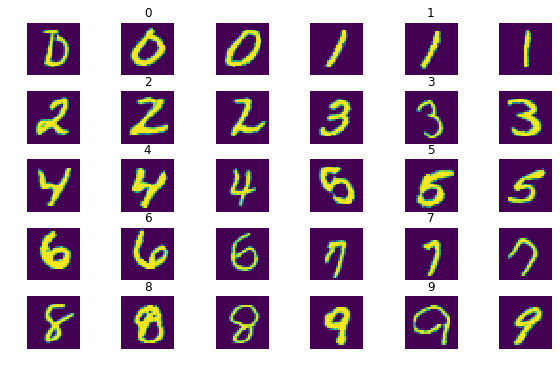

	Epoch: 90, Generator Loss: 0.3661940403779348, Discriminator Loss: [0.07084069 0.        ]


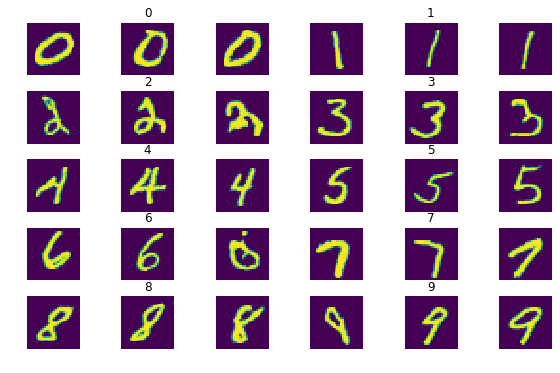

	Epoch: 91, Generator Loss: 0.3611326316992442, Discriminator Loss: [0.07082408 0.        ]


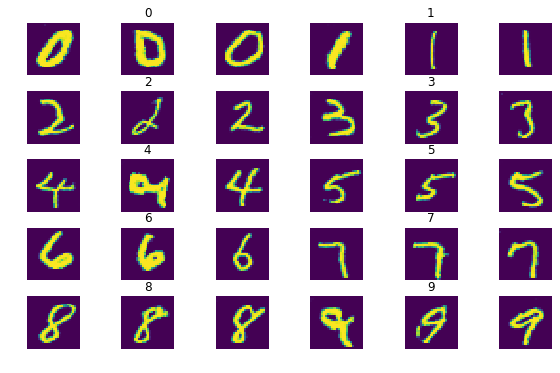

	Epoch: 92, Generator Loss: 0.36812152187029523, Discriminator Loss: [0.07096665 0.        ]


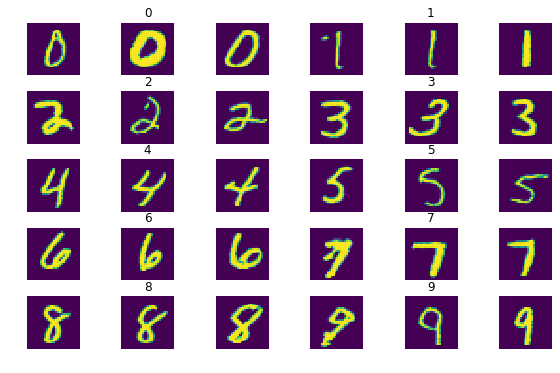

	Epoch: 93, Generator Loss: 0.3633956094582876, Discriminator Loss: [0.07134838 0.        ]


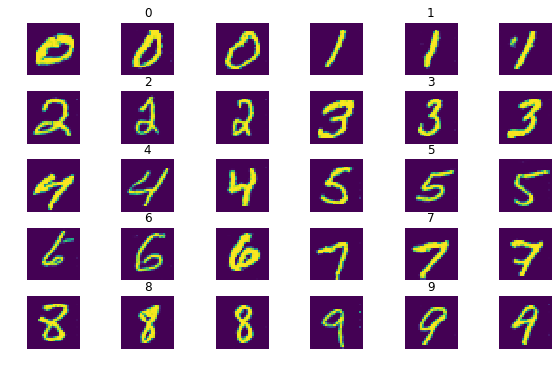

	Epoch: 94, Generator Loss: 0.36641459047794345, Discriminator Loss: [0.07104499 0.        ]


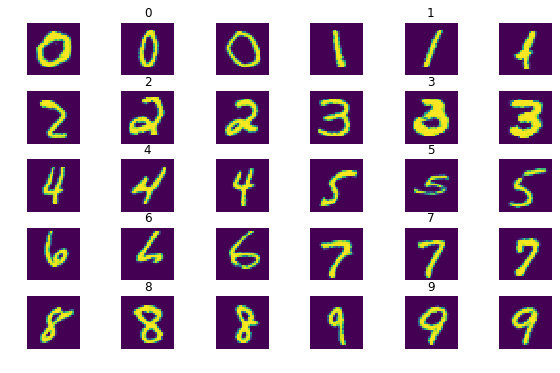

	Epoch: 95, Generator Loss: 0.3672977070013682, Discriminator Loss: [0.06966375 0.        ]


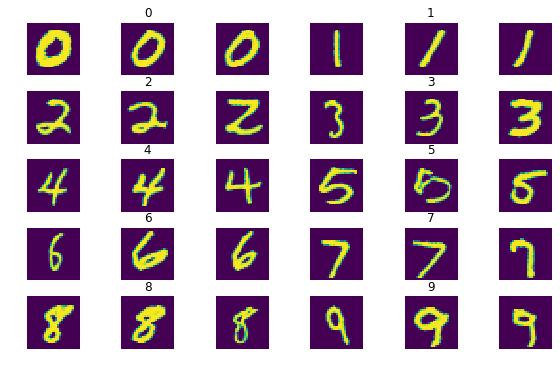

	Epoch: 96, Generator Loss: 0.36494301935036977, Discriminator Loss: [0.07025451 0.        ]


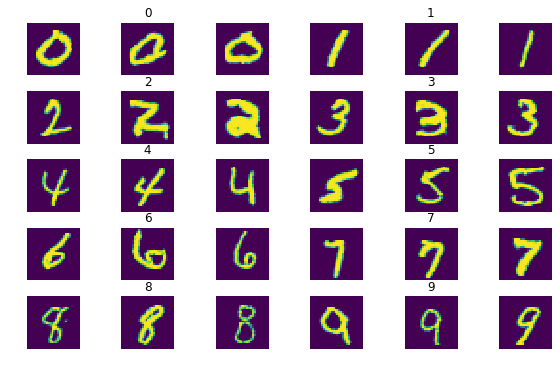

	Epoch: 97, Generator Loss: 0.36395447651545204, Discriminator Loss: [0.06998122 0.        ]


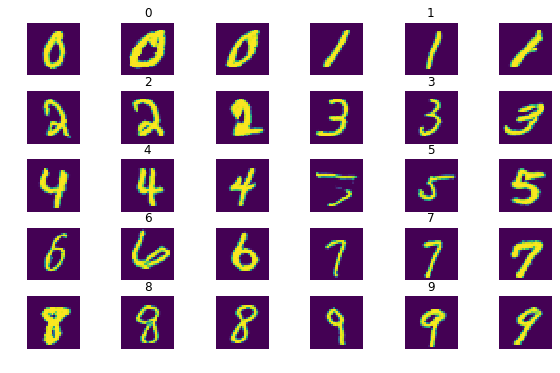

	Epoch: 98, Generator Loss: 0.36820891420046487, Discriminator Loss: [0.07007944 0.        ]


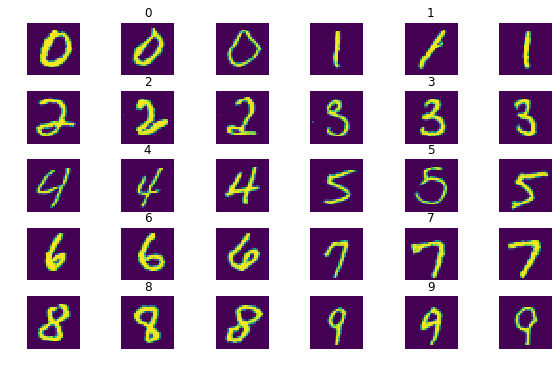

	Epoch: 99, Generator Loss: 0.3725166736046473, Discriminator Loss: [0.06912719 0.        ]


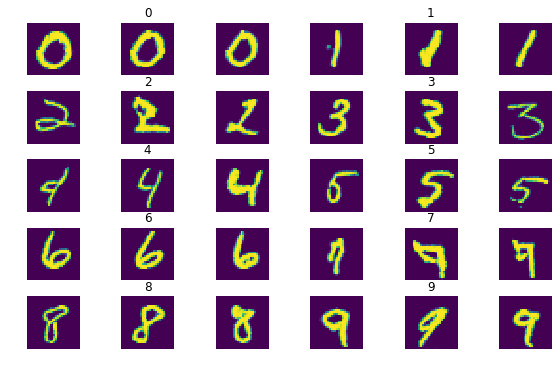

	Epoch: 100, Generator Loss: 0.3705349189043045, Discriminator Loss: [0.06932876 0.        ]


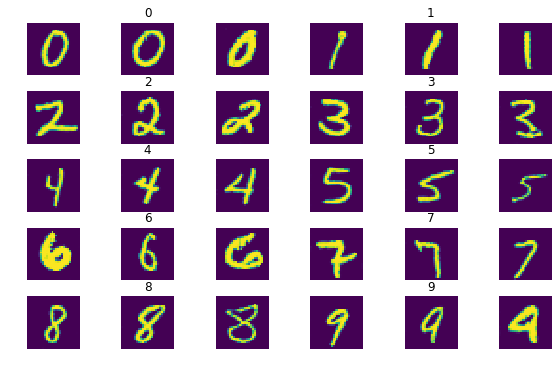

In [67]:
N_EPOCHS = 100
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    # We use same labels for generated images as in the real training batch
    generated_images = generator.predict([noise_data, labels])

    # Train on soft targets (add noise to targets as well)
    noise_prop = 0.05 # Randomly flip 5% of targets
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    
    # Store a random point for experience replay
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
    #If we have enough points, do experience replay
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
      break
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_samples("epoch" + str(epoch))


In [ ]:
label=one_hot_encode([0]*9)
print(label)

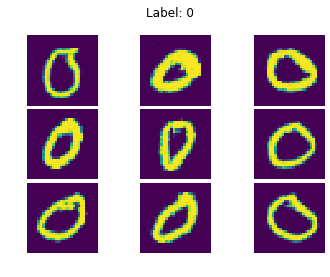

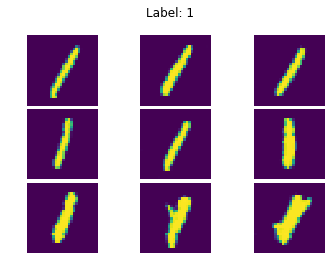

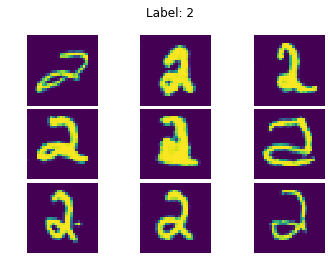

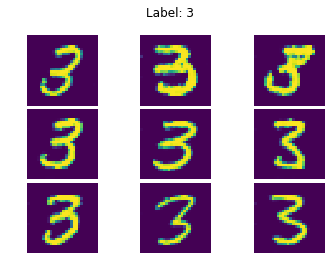

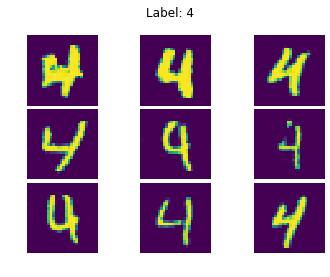

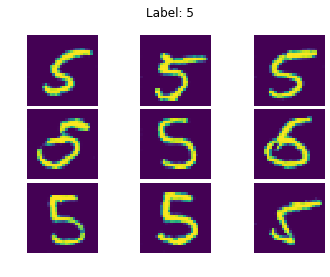

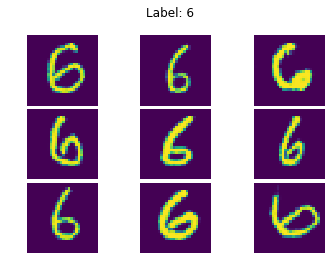

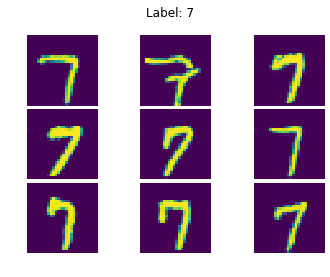

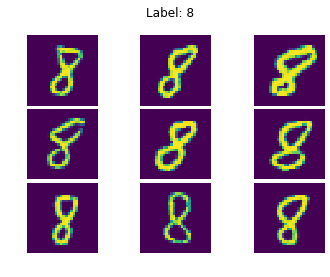

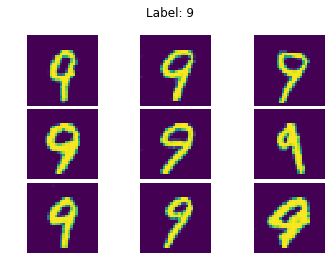

In [68]:
for classlabel in range(10):
  lbls = one_hot_encode([classlabel] * 9)
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict([noise, lbls])

  fig, axs = plt.subplots(3, 3)
  plt.subplots_adjust(hspace=0.05, wspace=0.05)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      plt.suptitle('Label: ' + str(classlabel))
      count += 1
  plt.show()
  plt.close()